# Explore the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

df = pd.read_csv(r'C:\Users\mohdr\Portfolio project\CSV\us_df_final_2015_2023.csv', index_col = 0)
df.set_index('date', inplace=True)
# df.info()  # Falls du Informationen über den DataFrame anzeigen möchtest
#df

### Downsample to weekly frequency by summing the daily values

In [47]:
# Convert index to DatetimeIndex
df.index = pd.to_datetime(df.index)

# Downsample to weekly frequency by summing the daily values
df_weekly = df.resample('W').sum()
#df_weekly

# Step 1: Check for stationarity of time series
## Method #1: time series plot

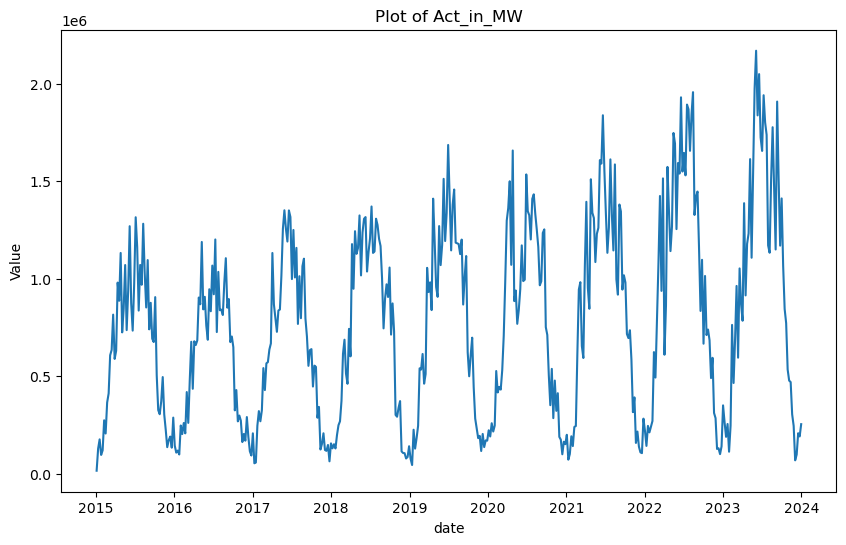

In [6]:
# Act_in_MW column is assuming
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly['Act_in_MW'])
plt.title('Plot of Act_in_MW')
plt.xlabel('date')
plt.ylabel('Value')
plt.show()

## Decomposition

### Act_in_MW' is the column want to decompose
Decomposing the Act_in_MW feature helps identify its trend, seasonal patterns, and noise. This breakdown aids in understanding its behavior over time, improving forecasting accuracy and revealing underlying patterns.

<Figure size 640x480 with 0 Axes>

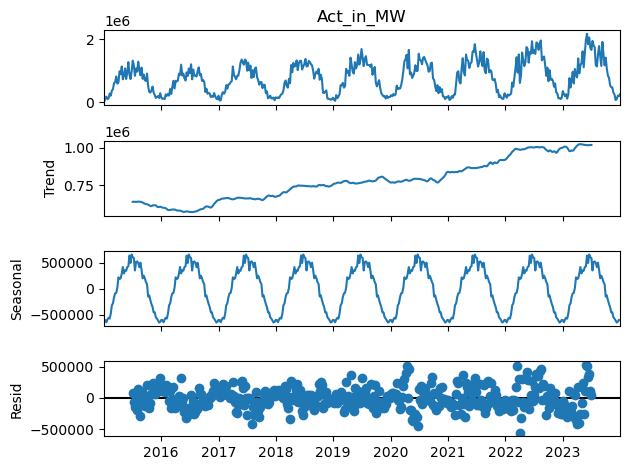

In [7]:
decomposition = seasonal_decompose(df_weekly['Act_in_MW'], period=52)  

# Plot the decomposed components
fig = plt.figure()  
fig = decomposition.plot()  
plt.show()

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

# Method #2: ADF Stationarity test 
The Augmented Dickey-Fuller (ADF) test is crucial for time series analysis as it determines whether a series is stationary or not. Stationarity is a fundamental assumption for many time series models, including ARIMA. By conducting the ADF test, we can assess the stationarity of the data, which is essential for making accurate predictions and ensuring the reliability of statistical inference.

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=52).mean()
    rolstd = timeseries.rolling(window=52).std()

    # Plot rolling statistics
    fig = plt.figure(figsize=(10, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

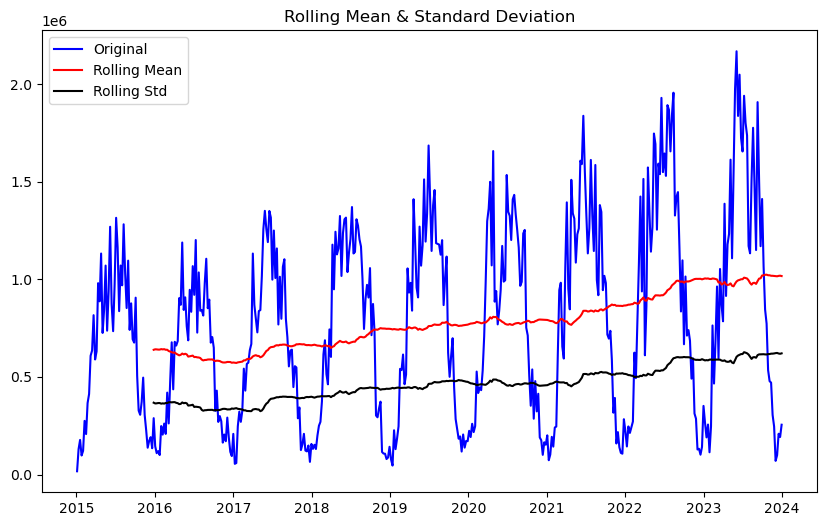

Results of Dickey-Fuller Test:
Test Statistic                -8.080309e+00
p-value                        1.467470e-12
#Lags Used                     1.600000e+01
Number of Observations Used    4.530000e+02
Critical Value (1%)           -3.444868e+00
Critical Value (5%)           -2.867941e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


In [9]:
# Beispielaufruf mit der Spalte 'Act_in_MW'
test_stationarity(df_weekly['Act_in_MW'])

### The Dickey-Fuller Test resulte
The Dickey-Fuller Test resulted in a test statistic of -8.080309e+00 and a very low p-value of 1.467470e-12, indicating strong evidence against the null hypothesis of non-stationarity. Therefore, we conclude that the time series is stationary.

# Transform to stationary: differencing
Differencing may not be necessary since the data is already stationary.

### Understanding Differencing in Time Series Analysis
Differencing involves subtracting each observation from its previous observation in a time series dataset. This process helps stabilize the mean of the series by removing trends or seasonal patterns.

In [ ]:
df['first_difference'] = df['Act_in_MW'] - df_weekly['Act_in_MW'].shift(1)
test_stationarity(df['first_difference'].dropna(inplace = False))

In [ ]:
# Beispiel: Berechnung der ersten Differenz
df['first_difference'] = df['Act_in_MW'].diff()

# Beispiel: Berechnung der saisonalen Differenz
df['seasonal_first_difference'] = df_weekly['first_difference'] - df['first_difference'].shift(52)

# Test auf Stationarität
test_stationarity(df['seasonal_first_difference'].dropna(inplace=False))

# Method #3: Determine ARIMA models parameters p,d, q and seasonal_pdq
### Step 1: ACF plot and PACF plot

These plots provide insights into the autocorrelation and partial autocorrelation structures of the time series data, which are crucial for selecting the appropriate parameters for the SARIMAX model.

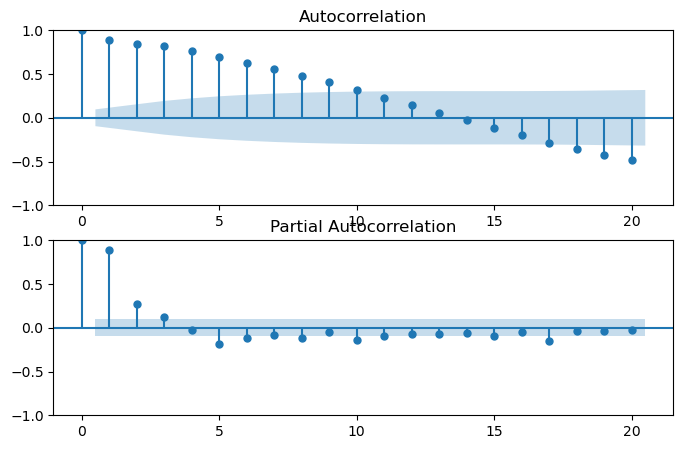

In [11]:
import statsmodels.api as sm
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_weekly.Act_in_MW.iloc[53:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_weekly.Act_in_MW.iloc[53:], lags=20, ax=ax2)

### Step 2: To determine the best parameter, cross-validation is applied
Cross-validation in time series involves iteratively partitioning data into training and validation sets to evaluate model performance while preserving the temporal order of observations.

In [14]:
import itertools
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import warnings

# Filter out the warning
warnings.filterwarnings("ignore")

# Parameterkombinationen für die Grid-Suche
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in pdq]  # Tägliche saisonale Komponente

best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

# Initialisierung des Kreuzvalidierungssplitters
tscv = TimeSeriesSplit(n_splits=5)

# Durchführung der Kreuzvalidierung
for train_index, test_index in tscv.split(df_weekly):
    train_data = df_weekly.iloc[train_index]
    test_data = df_weekly.iloc[test_index]

    # Finden der besten Parameter mit den Trainingsdaten
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data['Act_in_MW'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = mod.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
            except:
                continue


# Ausgabe der besten Parameter und des niedrigsten AIC-Werts
print('Beste Parameter (pdq, seasonal_pdq):', best_pdq, best_seasonal_pdq)
print('Bestes AIC:', best_aic)

Beste Parameter (pdq, seasonal_pdq): (0, 0, 0) (0, 1, 1, 52)
Bestes AIC: 4.0


# Step 3: Fit the SARIMAX model
Once you fit the SARIMAX model with the optimal parameters, focus on the model summary, diagnostics (like AIC and BIC), residual analysis, predictions, and forecasts. These outputs help assess the model's goodness of fit, performance, and parameter estimates.

In [43]:
# Modell mit den besten Parametern anpassen
mod = sm.tsa.statespace.SARIMAX(df_weekly['Act_in_MW'], order=(0,0,0), seasonal_order=(0,1,1,52), enforce_stationarity=True, enforce_invertibility=False)
results = mod.fit()

# Vorhersagen auf den Daten machen
pred = results.predict()

# Fehlermetriken berechnen
mae = np.mean(np.abs(pred - df_weekly['Act_in_MW']))
mse = np.mean((pred - df_weekly['Act_in_MW'])**2)
rmse = np.sqrt(mse)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 229983.78580318057
Mean Squared Error (MSE): 112703385042.95605
Root Mean Squared Error (RMSE): 335713.2482386658


In [44]:
# Vorhersagen des Modells
df_weekly['forecast'] = results.predict(start = '2015-01-04', end= '2023-12-31', dynamic= False)  

# Wahre Werte für das Jahr 2022
true_values = df_weekly['Act_in_MW']
# Berechnen des Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Berechnen des MAPE
mape = mean_absolute_percentage_error(true_values, df_weekly['forecast'])
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Absolute Percentage Error (MAPE): 35.50858168726491


In [ ]:
#print(results.summary())

#### Compare the actual values with the forecast using a graph

Text(0.5, 1.0, 'Actual vs Forecast Values')

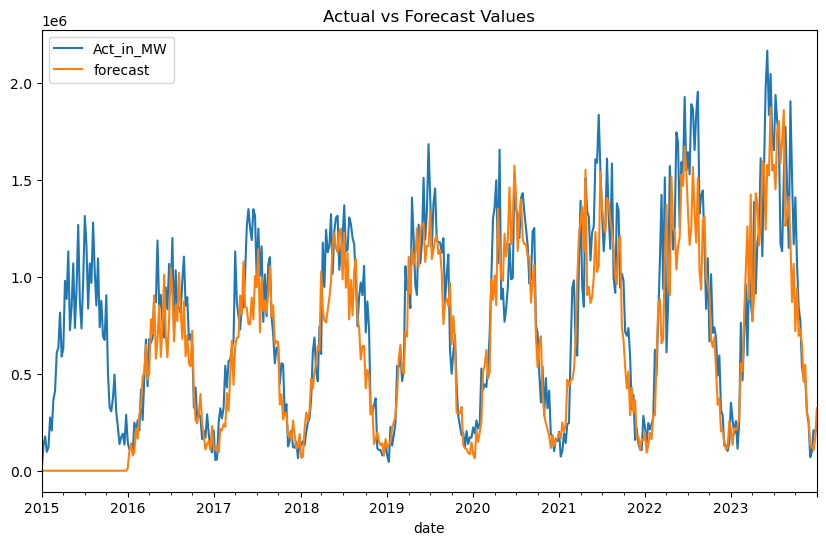

In [19]:
df_weekly['forecast'] = results.predict(start = '2015-01-04', end= '2023-12-31', dynamic= False)  
df_weekly[['Act_in_MW', 'forecast']].plot(figsize=(10, 6))
plt.title('Actual vs Forecast Values')
#df_weekly['forecast']

# Step 4: Make time series predictions

### Forecast future values (e.g., for next 52 steps)

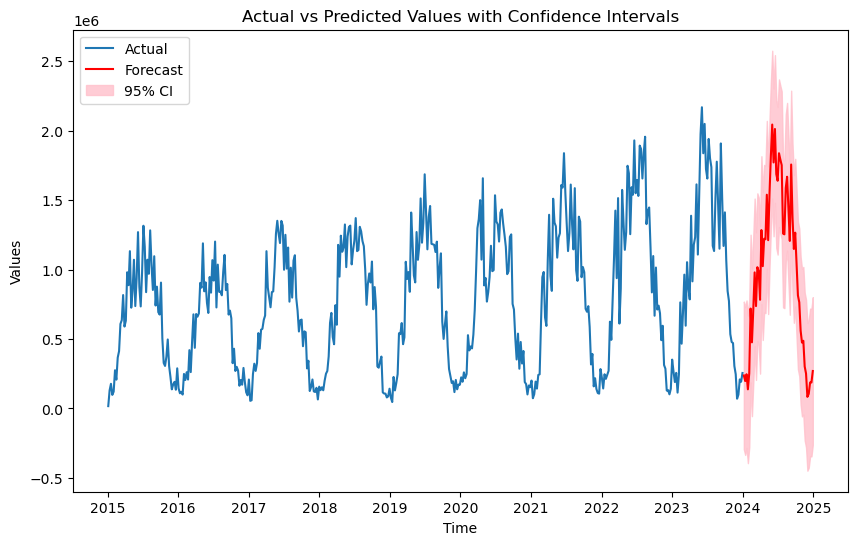

In [42]:
forecast_steps = 52
# Get forecast object
forecast = results.get_forecast(steps=forecast_steps)

# Extract forecasted values
forecast_values = forecast.predicted_mean

# Extract standard errors of forecasted values
forecast_errors = forecast.se_mean

# Define confidence levels
alpha_95 = 0.05
alpha_90 = 0.1

# Calculate confidence intervals based on forecast errors
conf_int_95 = [(val - 1.96 * err, val + 1.96 * err) for val, err in zip(forecast_values, forecast_errors)]
conf_int_90 = [(val - 1.645 * err, val + 1.645 * err) for val, err in zip(forecast_values, forecast_errors)]

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(df_weekly.index, df_weekly.Act_in_MW, label='Actual')
plt.plot(forecast_values.index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_values.index, [x[0] for x in conf_int_95], [x[1] for x in conf_int_95], color='pink', alpha=0.8, label='95% CI')
#plt.fill_between(forecast_values.index, [x[0] for x in conf_int_90], [x[1] for x in conf_int_90], color='orange', alpha=0.3, label='90% CI')
plt.title('Actual vs Predicted Values with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(loc='upper left')
plt.show()

# Step 5: Evaluate model predictions

### Calculate residuals

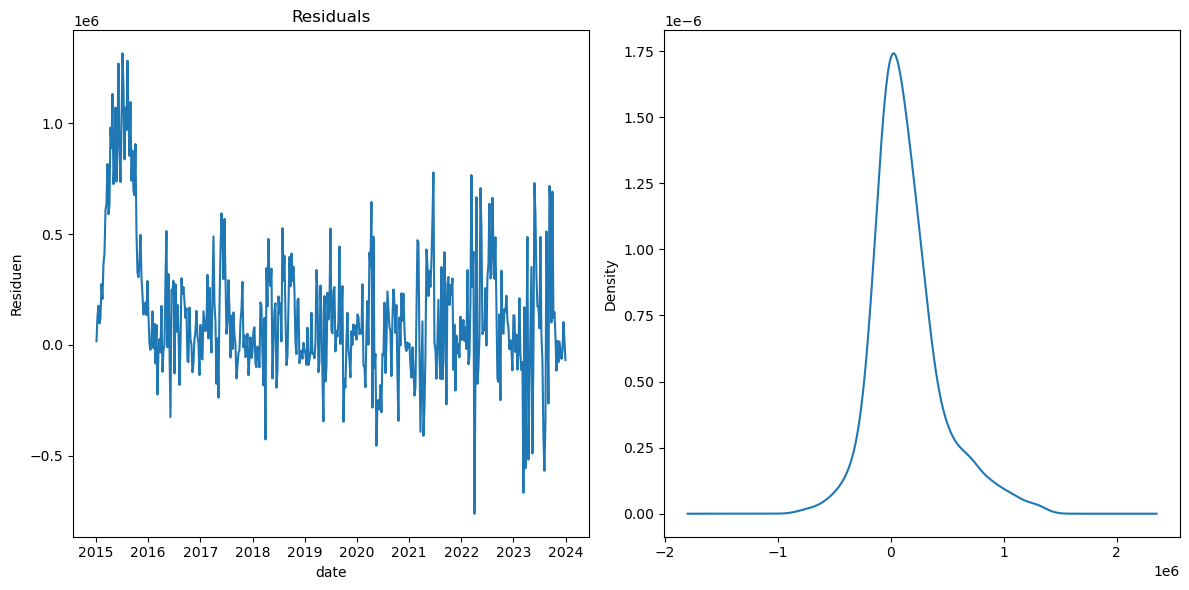

In [28]:
import seaborn as sns
import statsmodels.api as sm

# Berechnen Sie die Residuen
residuals = results.resid

# Plot der Residuen ab 2016
plt.figure(figsize=(12, 6))

# Plot der Residuen
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Residuals')
plt.xlabel('date')
plt.ylabel('Residuen')

# Dichtediagramm
plt.subplot(1, 2, 2)
residuals.plot(kind='kde')

plt.tight_layout()
plt.show()


Residual Mean Absolute Error: 229983.78580318057
Residual Mean Squared Error: 112703385042.95605
Residual Root Mean Squared Error: 335713.2482386658


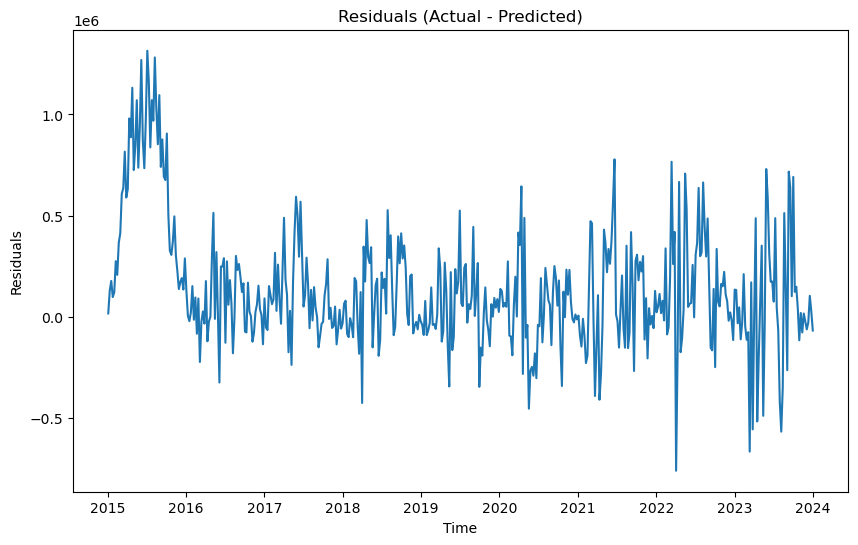

In [39]:
# Calculate residuals
residuals = df_weekly['Act_in_MW'] - df_weekly['forecast']

# Calculate error metrics for residuals
residual_mae = np.mean(np.abs(residuals))
residual_mse = np.mean(residuals**2)
residual_rmse = np.sqrt(residual_mse)

# Print error metrics for residuals
print("Residual Mean Absolute Error:", residual_mae)
print("Residual Mean Squared Error:", residual_mse)
print("Residual Root Mean Squared Error:", residual_rmse)

# Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals (Actual - Predicted)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.show()

# Shapiro-Wilk-Test auf Normalverteilung der Residuen

In [45]:
from scipy import stats

# Shapiro-Wilk-Test auf Normalverteilung der Residuen
shapiro_test_stat, shapiro_p_value = stats.shapiro(residuals)
print('Shapiro-Wilk-Test Statistik:', shapiro_test_stat)
print('Shapiro-Wilk-Test p-Wert:', shapiro_p_value)

Shapiro-Wilk-Test Statistik: 0.9292163252830505
Shapiro-Wilk-Test p-Wert: 4.141616723510842e-14
